In [13]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
import os
import pandas as pd
import numpy as np
import torch
import pyreadr
import config_91
import argparse
import utils_91
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

from Dataset import CNS
from torch.utils.data import DataLoader
from Model import NN91
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
from utils_91 import make_ndarray_from_csv, get_int_label
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight
from sklearn import preprocessing
from tqdm import tqdm
from sklearn.metrics import confusion_matrix

clf_cfg = config_91.classifier_config

In [15]:
VAL_PROBS_DIR = clf_cfg['VAL_PROBS_DIR']
VAL_LABELS_DIR = clf_cfg['VAL_LABELS_DIR']
fold = '1.0'
with open(os.path.join(VAL_PROBS_DIR, f'{fold}.pkl'), 'rb') as handle:
    val_probs = pickle.load(handle)

with open(os.path.join(VAL_LABELS_DIR, f'{fold}.pkl'), 'rb') as handle:
    val_labels = pickle.load(handle)

In [16]:
val_labels

array([57, 50, 24, 85, 50, 47, 88, 26, 82, 28, 50, 57, 40,  6, 63, 39,  0,
       63, 88, 58, 27,  3, 84,  9, 63, 56, 64, 50, 22, 61, 64, 43,  4, 67,
       27,  4, 39, 90, 64, 35, 42, 87,  4, 80, 48, 57, 19, 76, 28, 18, 57,
        8, 37,  9,  2, 67, 15, 27,  5, 17, 30, 90, 24, 80, 22, 70, 50, 20,
       35,  9,  1, 30, 82, 50, 22, 47, 64, 35, 80, 27, 22, 60,  1, 78, 56,
        5, 22, 38, 68, 39, 39, 80, 32, 50, 39, 63, 34, 41, 38, 16, 84, 28,
       31, 90, 58, 43, 80, 63, 46, 15, 50, 29, 57,  1, 41, 69,  9,  9, 57,
       38, 38, 22, 56, 50, 23, 32,  5, 57, 39, 46, 68, 80, 38, 76, 84, 35,
       55, 22,  3, 29, 39, 79, 20,  0, 29, 10, 83, 58,  9, 57, 46, 73, 44,
       58, 59, 58, 20, 63, 56, 27, 39, 34, 57, 57, 88, 18, 50, 17, 34, 60,
        0, 29, 39, 85, 29, 38, 28, 40, 59, 33, 75, 89, 49, 46, 65, 64, 69,
       63,  0, 27, 41, 58, 64, 78, 17, 88, 28, 14,  3, 83,  0, 51, 86, 27,
       52, 35, 22, 85,  0, 64, 29, 64, 88, 29, 34, 39, 27, 56, 11, 29,  3,
        8,  0, 50,  4, 15

In [17]:
positions = np.argmax(val_probs, axis=1)

avg_confidence = 0

for i in range(len(positions)):
    confidence = val_probs[i][positions[i]]
    avg_confidence += confidence
avg_confidence = avg_confidence/len(positions)
print(avg_confidence)

0.963183717811527


In [18]:
def plot_confusion_matrix(confusion_matrix, class_names, figsize = (15,10), fontsize=12):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.

    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix.
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (100,70).
    fontsize: int
        Font size for axes labels. Defaults to 14.
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt = "d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [19]:
# _, idx = np.unique(val_labels, return_index=True)
# unique_labels = val_labels[sorted(idx)]
# unique_labels


In [20]:
# Index the matrix in the order appeared in the labe_dict
cfs_matrix = confusion_matrix(val_labels, np.argmax(val_probs, axis=1), labels=list(utils_91.label_dict.values()))
cfs_matrix, cfs_matrix.shape

(array([[15,  1,  0, ...,  0,  0,  0],
        [ 0, 10,  0, ...,  0,  0,  0],
        [ 0,  0,  5, ...,  0,  0,  0],
        ...,
        [ 0,  0,  0, ...,  8,  0,  0],
        [ 0,  0,  0, ...,  0,  2,  0],
        [ 0,  0,  0, ...,  0,  0,  4]]),
 (91, 91))

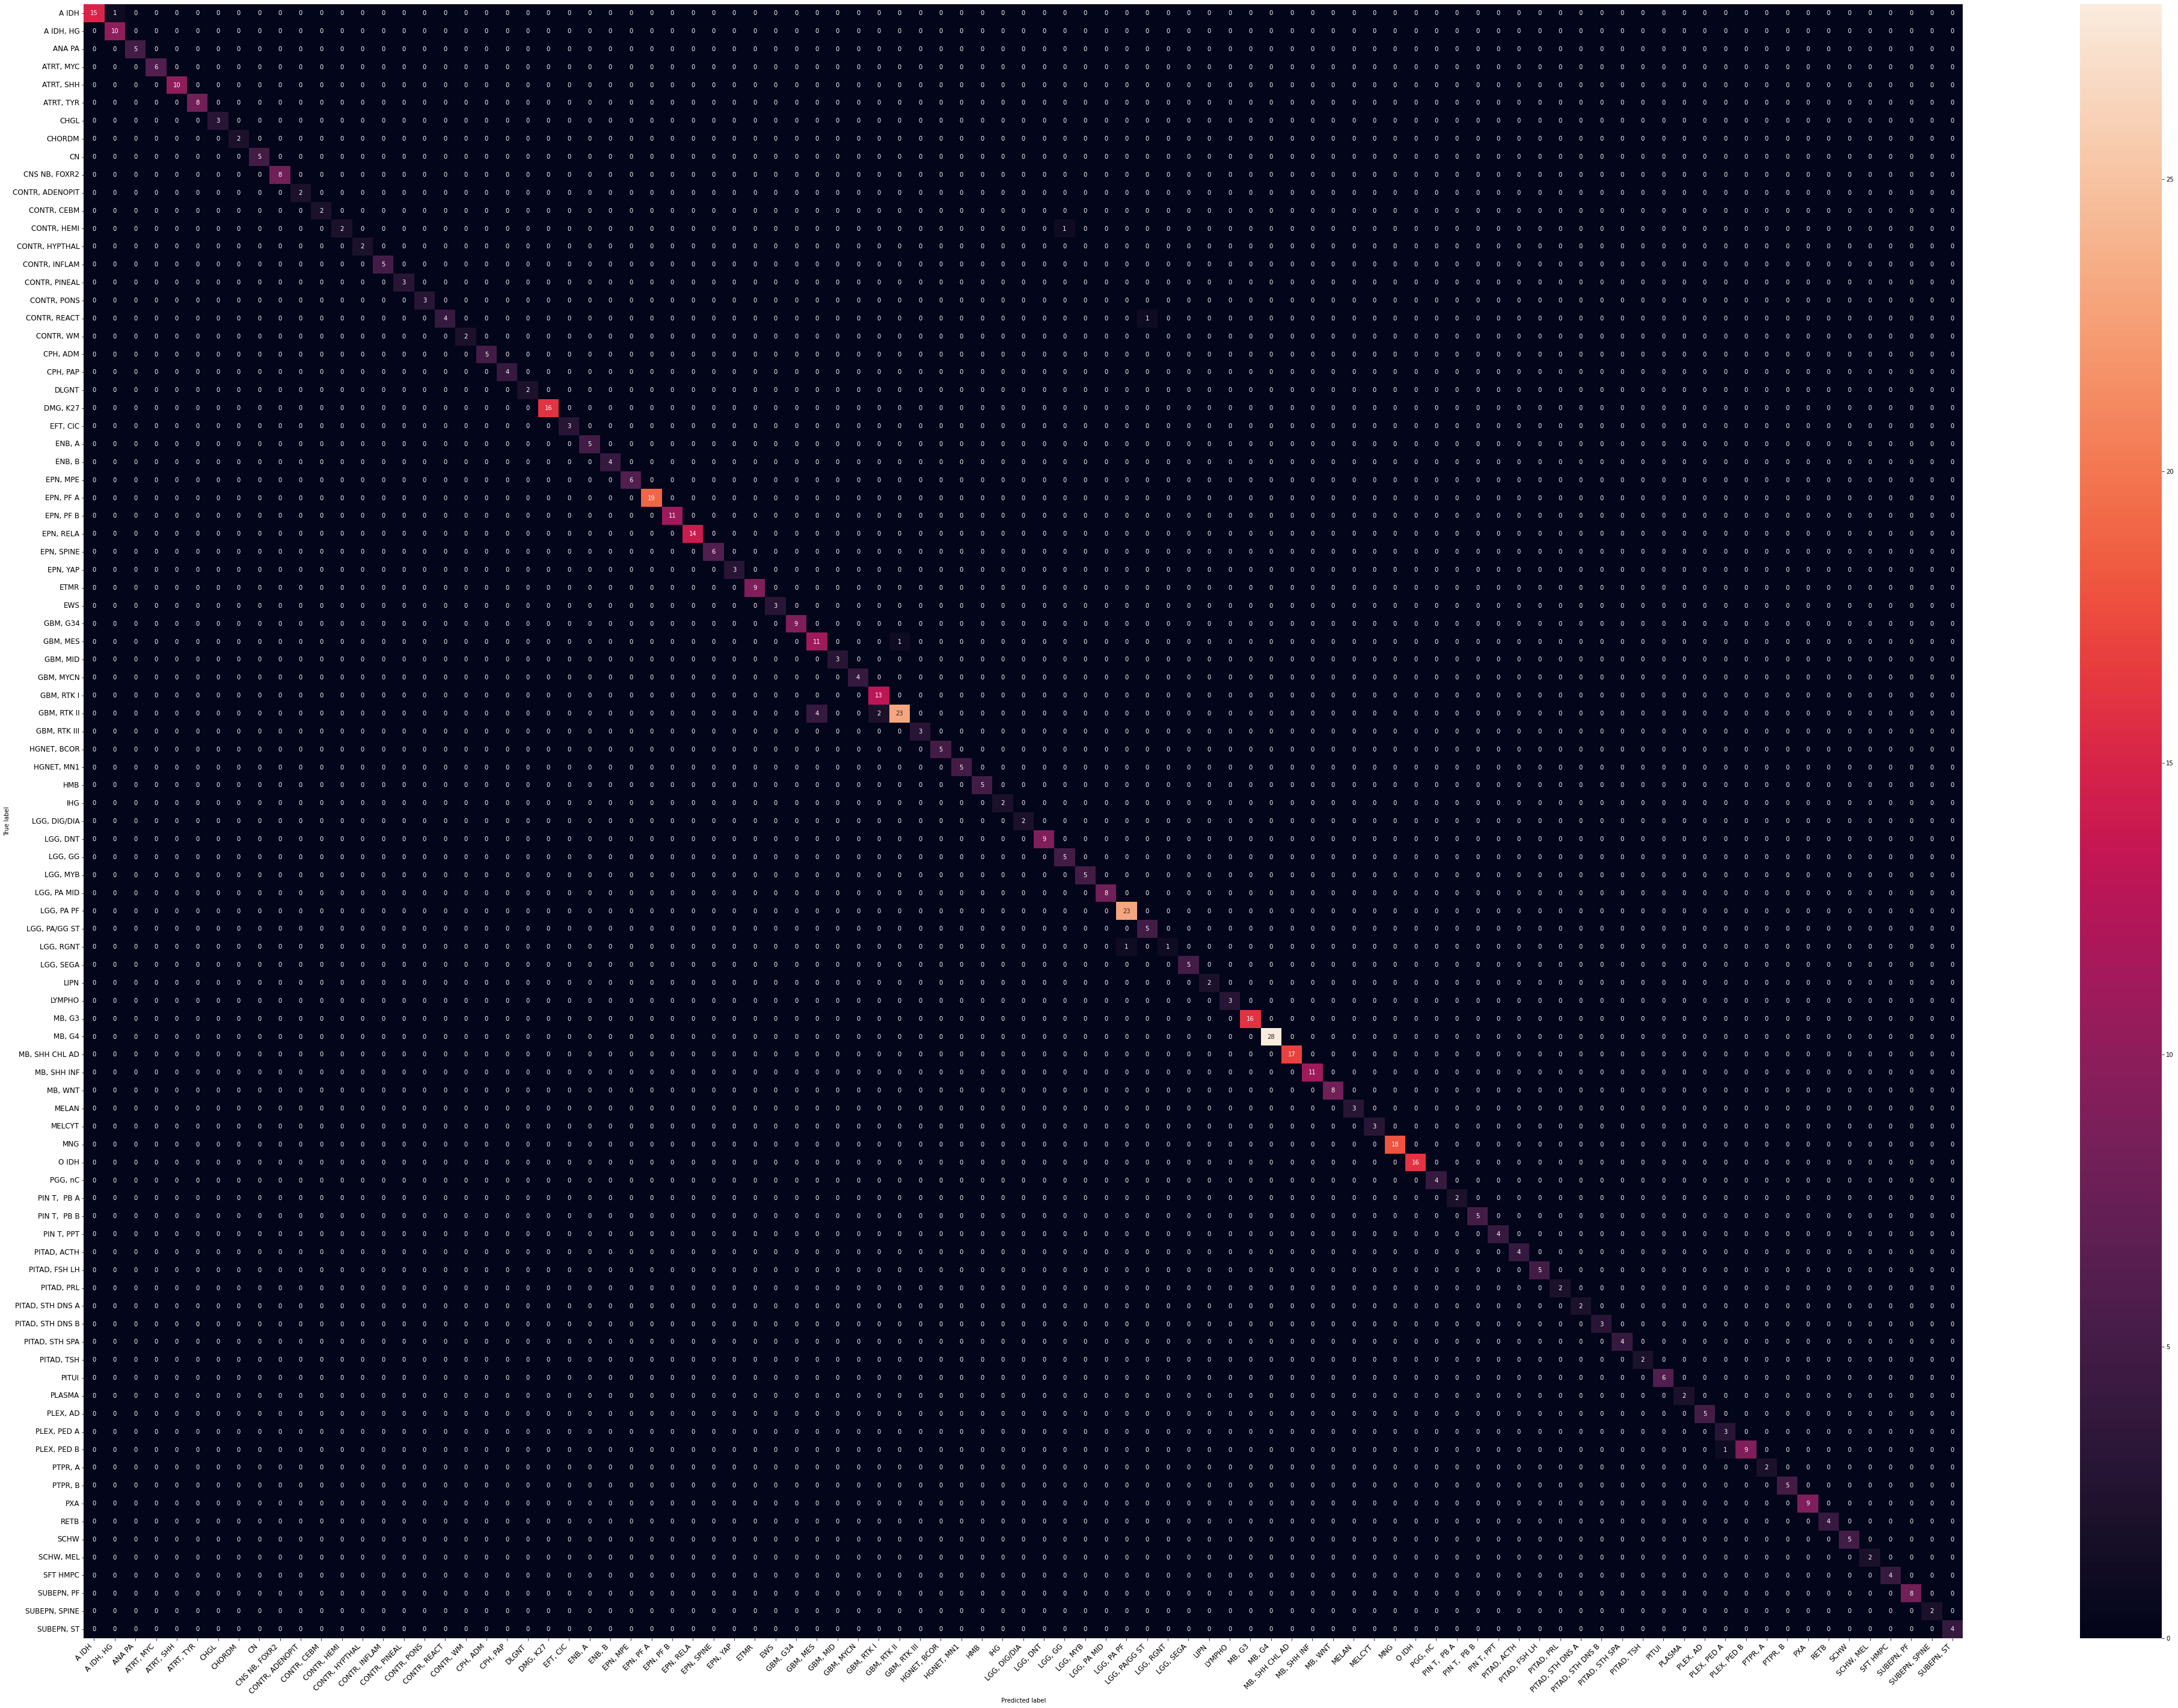

In [21]:
plot_confusion_matrix(cfs_matrix, list(utils_91.label_dict.keys()), figsize=(70, 50))

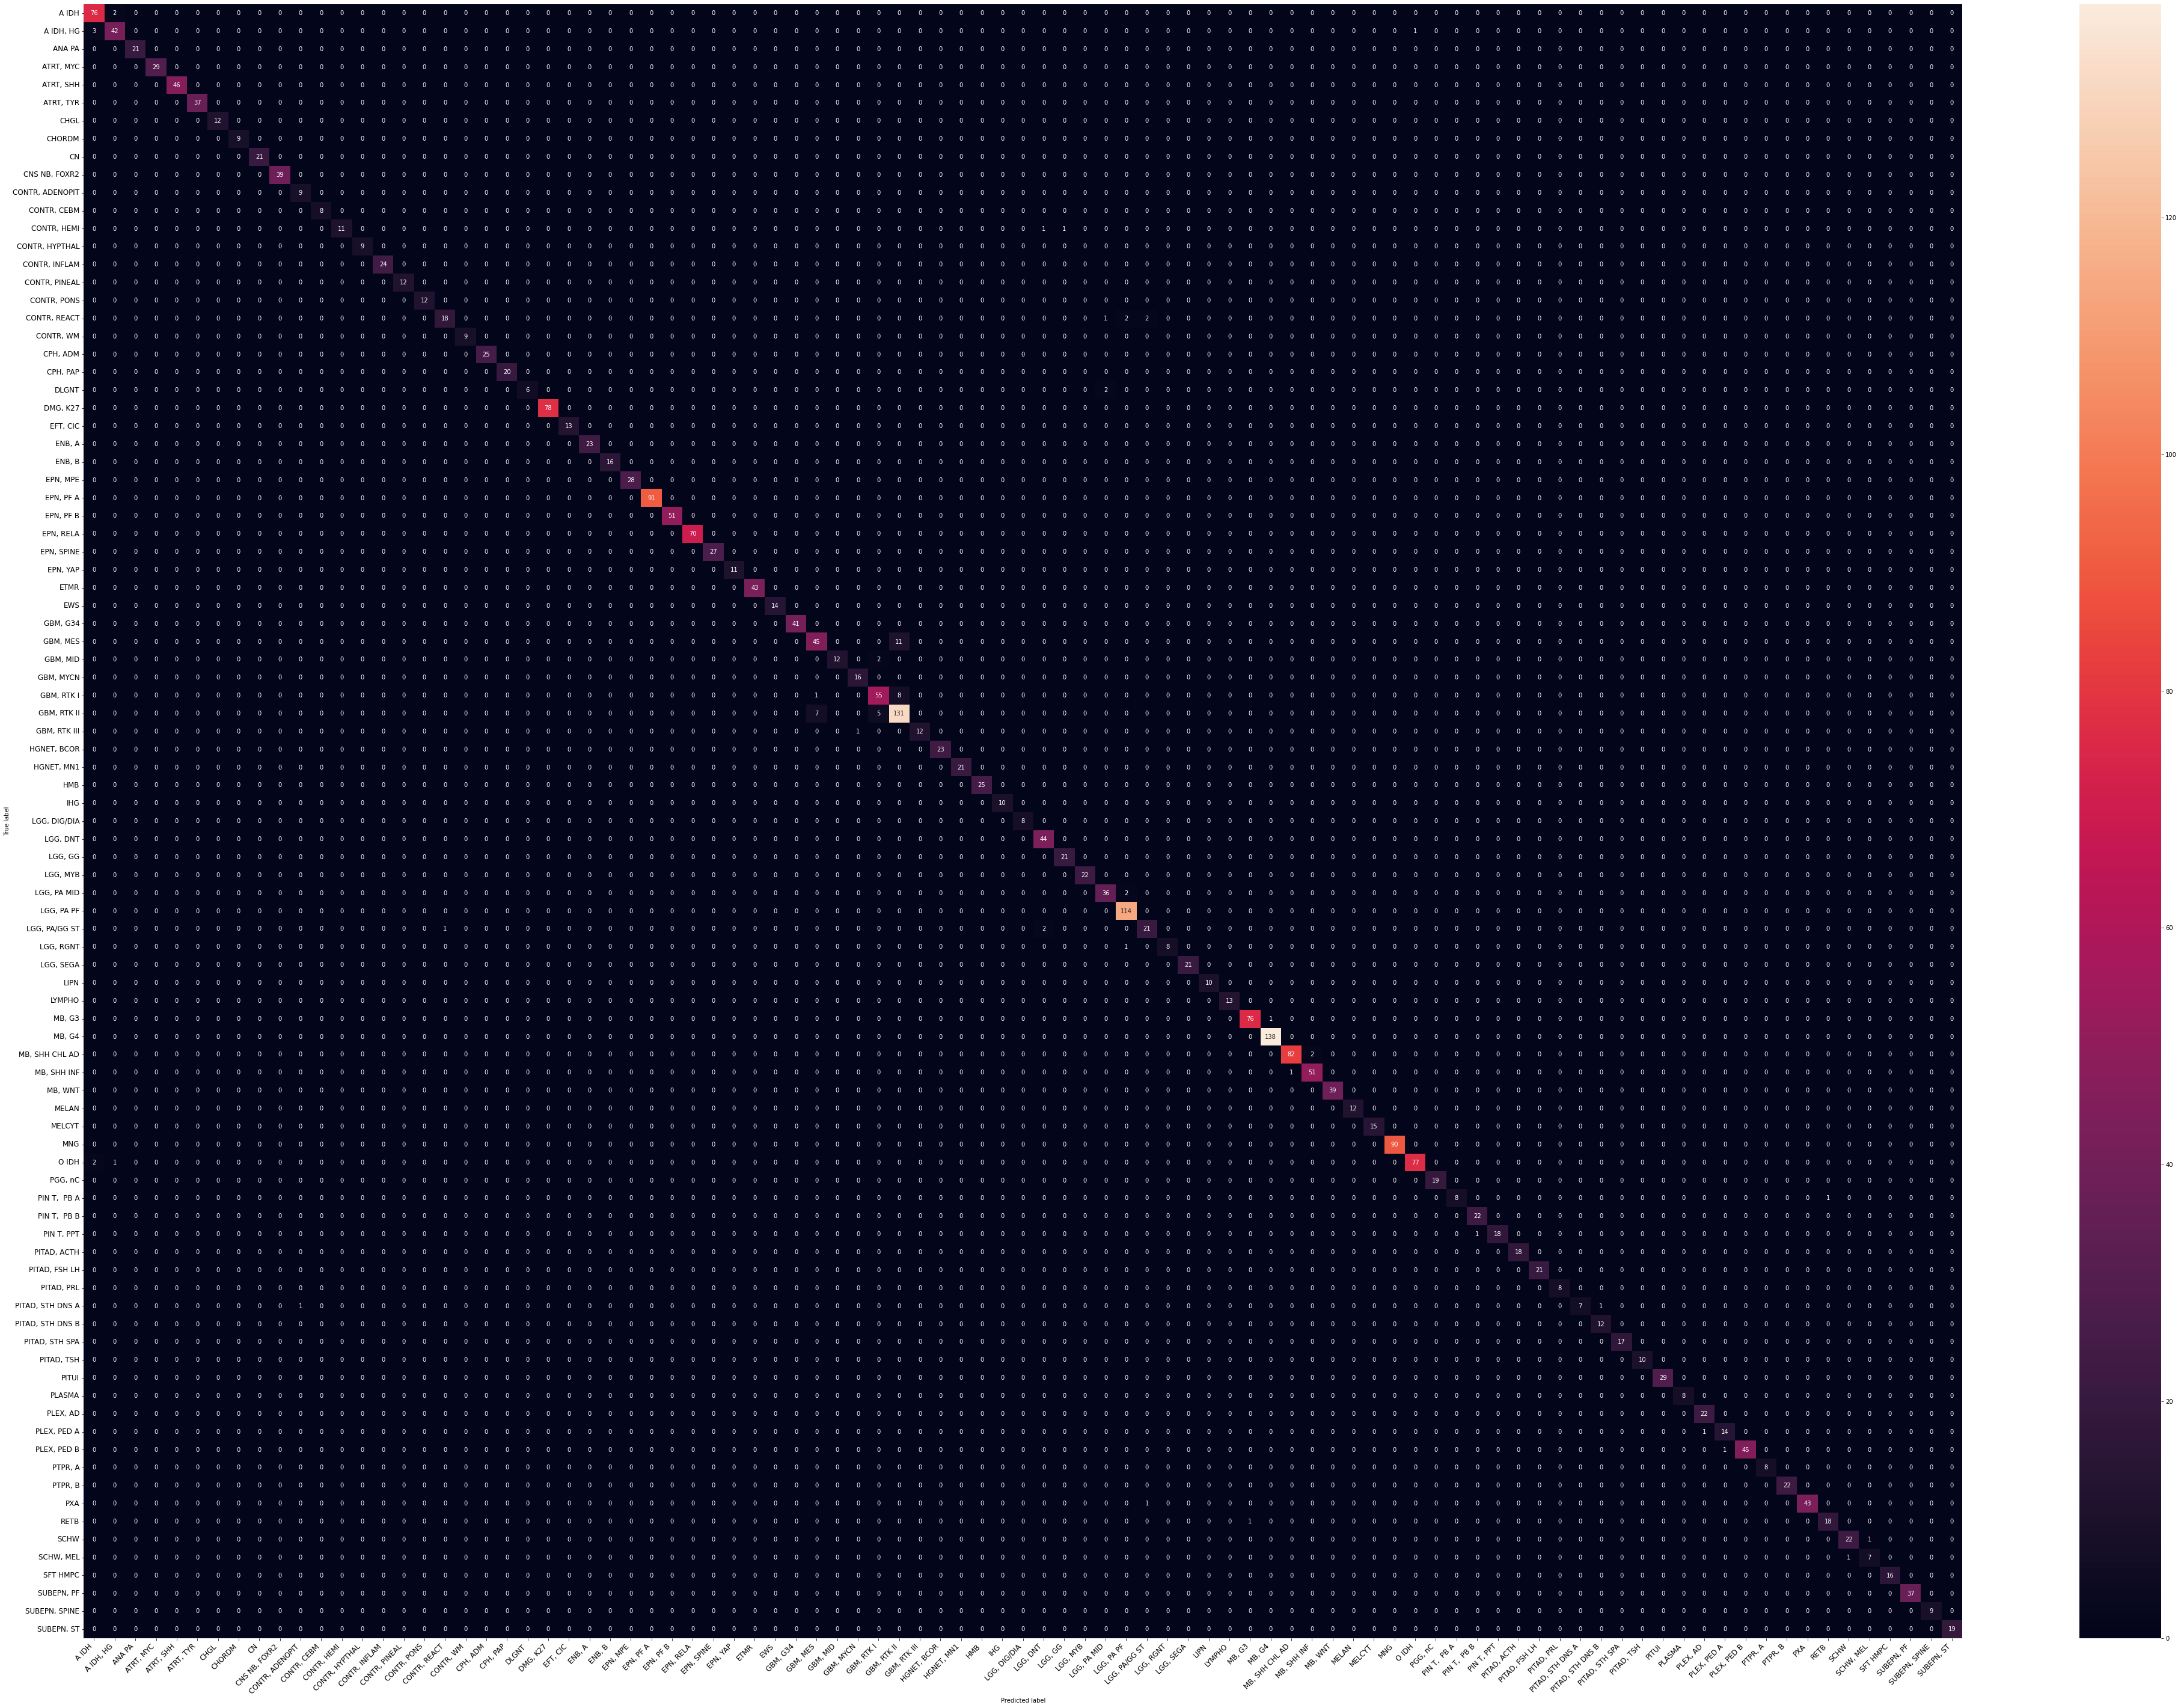

In [25]:
folds = utils_91.outer_folds
sum_cfs_matrix = np.zeros((91, 91), dtype=int)
for fold in folds:
    with open(os.path.join(VAL_PROBS_DIR, f'{fold}.pkl'), 'rb') as handle:
        val_probs = pickle.load(handle)

    with open(os.path.join(VAL_LABELS_DIR, f'{fold}.pkl'), 'rb') as handle:
        val_labels = pickle.load(handle)
    cfs_matrix = confusion_matrix(val_labels, np.argmax(val_probs, axis=1), labels=list(utils_91.label_dict.values()))
    sum_cfs_matrix += cfs_matrix
plot_confusion_matrix(sum_cfs_matrix, list(utils_91.label_dict.keys()), figsize=(70, 50))

In [24]:
sum_cfs_matrix

array([[76.,  2.,  0., ...,  0.,  0.,  0.],
       [ 3., 42.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0., 21., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ..., 37.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  9.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0., 19.]])